In [1]:
import os
import sys
import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

sys.path.append('../')

from mpl_settings_v3 import *

%matplotlib inline

draft_figs_dir = '../../../drafts/results_summary/figs'
figs_dir = '../../../figs/clustering'

linestyles = ['-', '--']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [28]:
def protocolName(mode, init_mu, step, samples, transit, decorr, rampe):
    
    protocol = '{}_{}_muInit{:.6f}_step{:.6f}_samples{:06}_transit{:06d}_decorr{:06d}'.format(mode, rampe, init_mu, step, samples, transit, decorr)
    
    return protocol

def protocolNameNew(mode, init_mu, step, samples, transit, decorr, rampe, time_scaling):
    
    protocol = '{}_{}_muInit{:.6f}_step{:.6f}_samples{:06}_transit{:06d}_decorr{:06d}_timeScaling{:.6f}'.format(mode, rampe, init_mu, step, 
                                                                                                                samples, transit, decorr, time_scaling)
    
    return protocol

get_mu = lambda name: float(name.split('mu')[1].split('_')[0])
get_sample = lambda name: int(name.split('sample')[1].split('.')[0])

### Protocol data

In [3]:
mode = 'maxC'
min_mu = 0
max_mu = 10
step = 0.1
samples = 100
decorr = 10
transit = 100
seed = 0

# Real networks

In [4]:
net_dir = '../../../networks/real'

In [5]:
rampes = ['annealing', 'cooling']
seed_dir = 'seed{:05}'.format(seed)
columns = ['mu', 'sample', 'C', 'Cws']

networks = ['terrorists_simple_gcc',
            'ca-netscience', 
            'ca-GrQc',
            'bio-yeast',
            'bio-diseasome',
            'bio-celegans',
            'powergrid',
            'euroroad_simple_gcc',
            'CElegansNeural',
            'MMusculusPIN_simple_gcc',
            'HPyloriPIN_simple_gcc',
            'jazz_simple_gcc',
            #'polblogs_simple_gcc',
            #'EColiPIN_simple_gcc',
            #'US-airports-500'
            ]

sizes = []
for network in networks:
    full_input_file = os.path.join(net_dir, network, network + '.txt')
    try:
        g = ig.Graph().Read_Edgelist(full_input_file, directed=False)
    except:
        print('ERROR: Could not read file', network)
        continue
    N = g.vcount()
    M = g.ecount()
    sizes.append([network, N, M])
    
networks = list(zip(*sorted(sizes, key=lambda x: x[2])))[0]

dfs = {}
for network in networks:
    print(network)
    dfs[network] = {}
    for rampe in rampes:

        if rampe == 'annealing':
            init_mu = min_mu
        else:
            init_mu = max_mu
        protocol = protocolName(mode, init_mu, step, samples, transit, decorr, rampe)
        input_dir = os.path.join(net_dir, network, protocol, seed_dir)
        if not os.path.isdir(input_dir):
            print(input_dir)

        csv_file = os.path.join(input_dir, rampe + '.csv')   
        if os.path.isfile(csv_file):
            df = pd.read_csv(csv_file)
        else:
            files = sorted(os.listdir(input_dir))  
            data = []
            for f in files:
                mu = get_mu(f)
                sample = get_sample(f)
                full_path = os.path.join(input_dir, f)
                g = ig.Graph().Read_Edgelist(full_path, directed=False)
                C = g.transitivity_undirected(mode='zero')
                Cws = g.transitivity_avglocal_undirected(mode='zero')
                data.append([mu, sample, C, Cws])

            df = pd.DataFrame(data, columns=columns)
            df.to_csv(csv_file)
        dfs[network][rampe] = df

terrorists_simple_gcc
ca-netscience
bio-diseasome
euroroad_simple_gcc
HPyloriPIN_simple_gcc
MMusculusPIN_simple_gcc
bio-yeast
bio-celegans
CElegansNeural
jazz_simple_gcc
powergrid
ca-GrQc


terrorists
ca-netscience
bio-diseasome
euroroad
HPyloriPIN
MMusculusPIN
bio-yeast
bio-celegans
CElegansNeural
jazz
powergrid
ca-GrQc


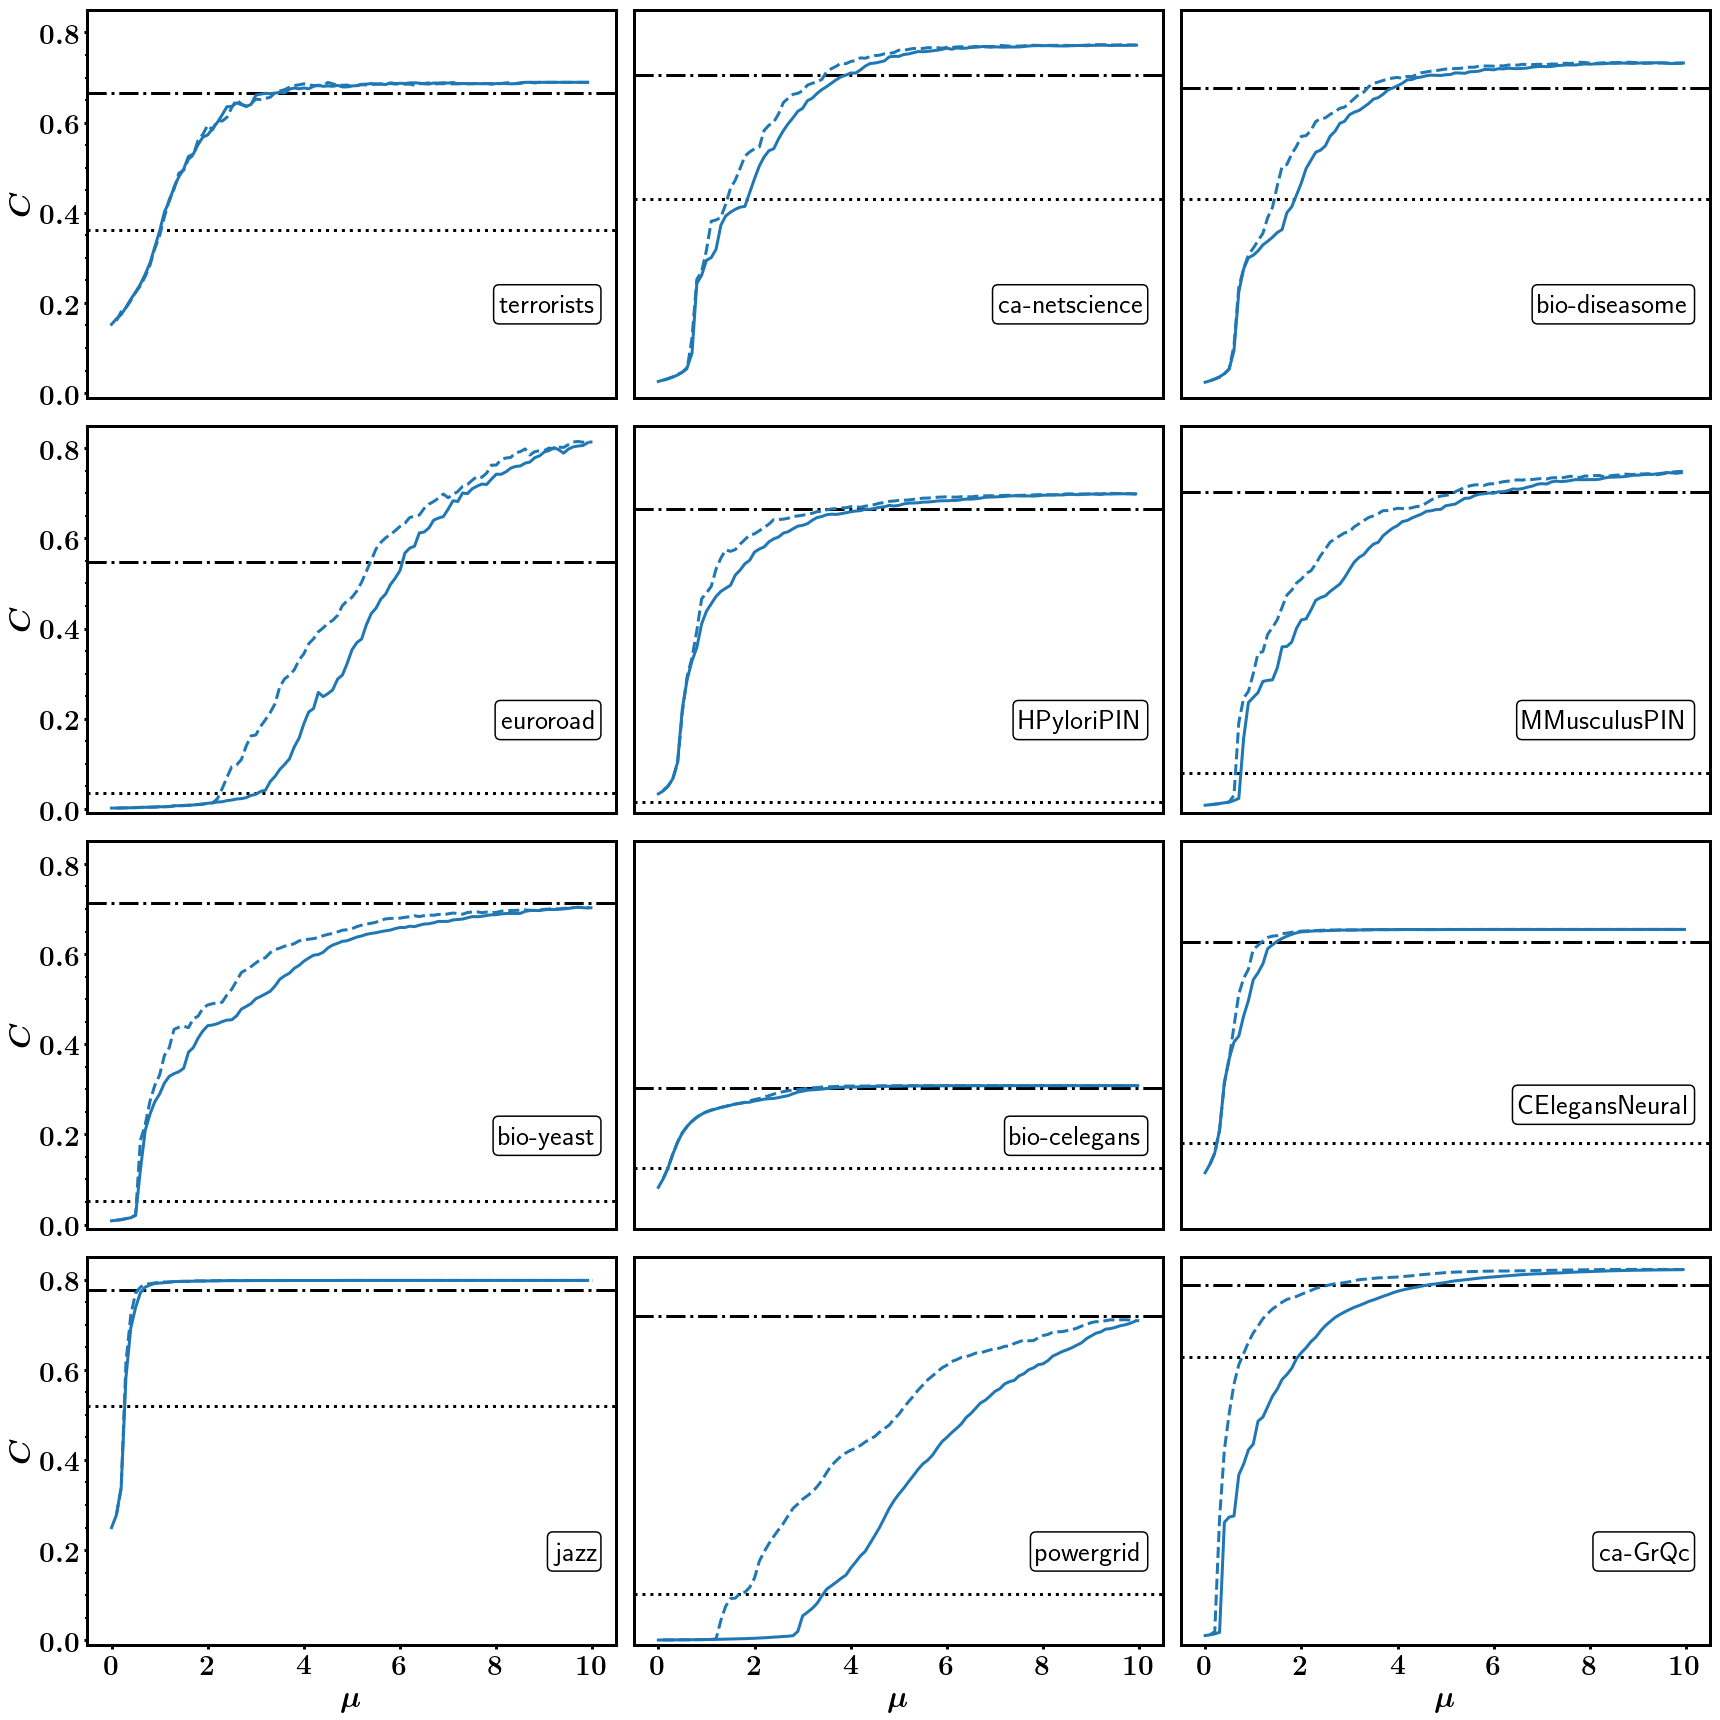

In [6]:
input_dir = '../../../data/clustering'
full_file_path = os.path.join(input_dir, 'Cnorm_data.pickle')
with open(full_file_path, 'rb') as f:
    data = pickle.load(f)

text_x = 0.96
text_dict = {'CElegansNeural': (text_x, 0.3)}

ncols, nrows = 3, len(networks) // 3 + (len(networks)%3 > 0)
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)


for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axes[:,0]:
    ax.set_ylabel(r'$C$')
    ax.set_yticks(np.arange(0, 1.2, 0.2))
for ax in axes[-1,:]:
    ax.set_xlabel(r'$\mu$')
    ax.set_xticks(np.arange(0, 11, 2))
    

    
for ax, network in zip(axes.flatten(), networks):

    C = data[network]['C'][0]
    maxC = data[network]['C'][2]
    ax.axhline(C, linestyle=':', color='k')
    ax.axhline(maxC, linestyle='-.', color='k')
    #maxCws = data[network]['Cws'][2]
    #ax.axhline(maxCws, linestyle='-.', color=colors[1])
    
    for i, rampe in enumerate(rampes):
        df = dfs[network][rampe]
        mean_df = df.groupby(by='mu').mean()
        mu_values = mean_df.index
        C_values = mean_df.C
        Cws_values = mean_df.Cws
        ax.plot(mu_values, C_values, color=colors[0], linestyle=linestyles[i], label='')
    
    if '_simple_gcc' in network:
        title = network.split('_')[0]
    else:
        title = network
    print(title)
    ax.set_ylim(-0.01, 0.85)
    bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    
    if network in text_dict:
        ax.text(*text_dict[network], title, bbox=bbox, transform=ax.transAxes, fontsize=28, 
                horizontalalignment='right')
    else:
        ax.text(text_x, 0.22, title, bbox=bbox, transform=ax.transAxes, fontsize=28, 
                horizontalalignment='right')
    #ax.legend(loc='best')
    
plt.tight_layout()
plt.savefig(os.path.join(draft_figs_dir, 'Cmax_MC_and_greedy.pdf'))
plt.savefig(os.path.join(figs_dir, 'Cmax_MC_and_greedy.png'))
plt.show()

terrorists
ca-netscience
bio-diseasome
euroroad
HPyloriPIN
MMusculusPIN
bio-yeast
bio-celegans
CElegansNeural
jazz
powergrid
ca-GrQc


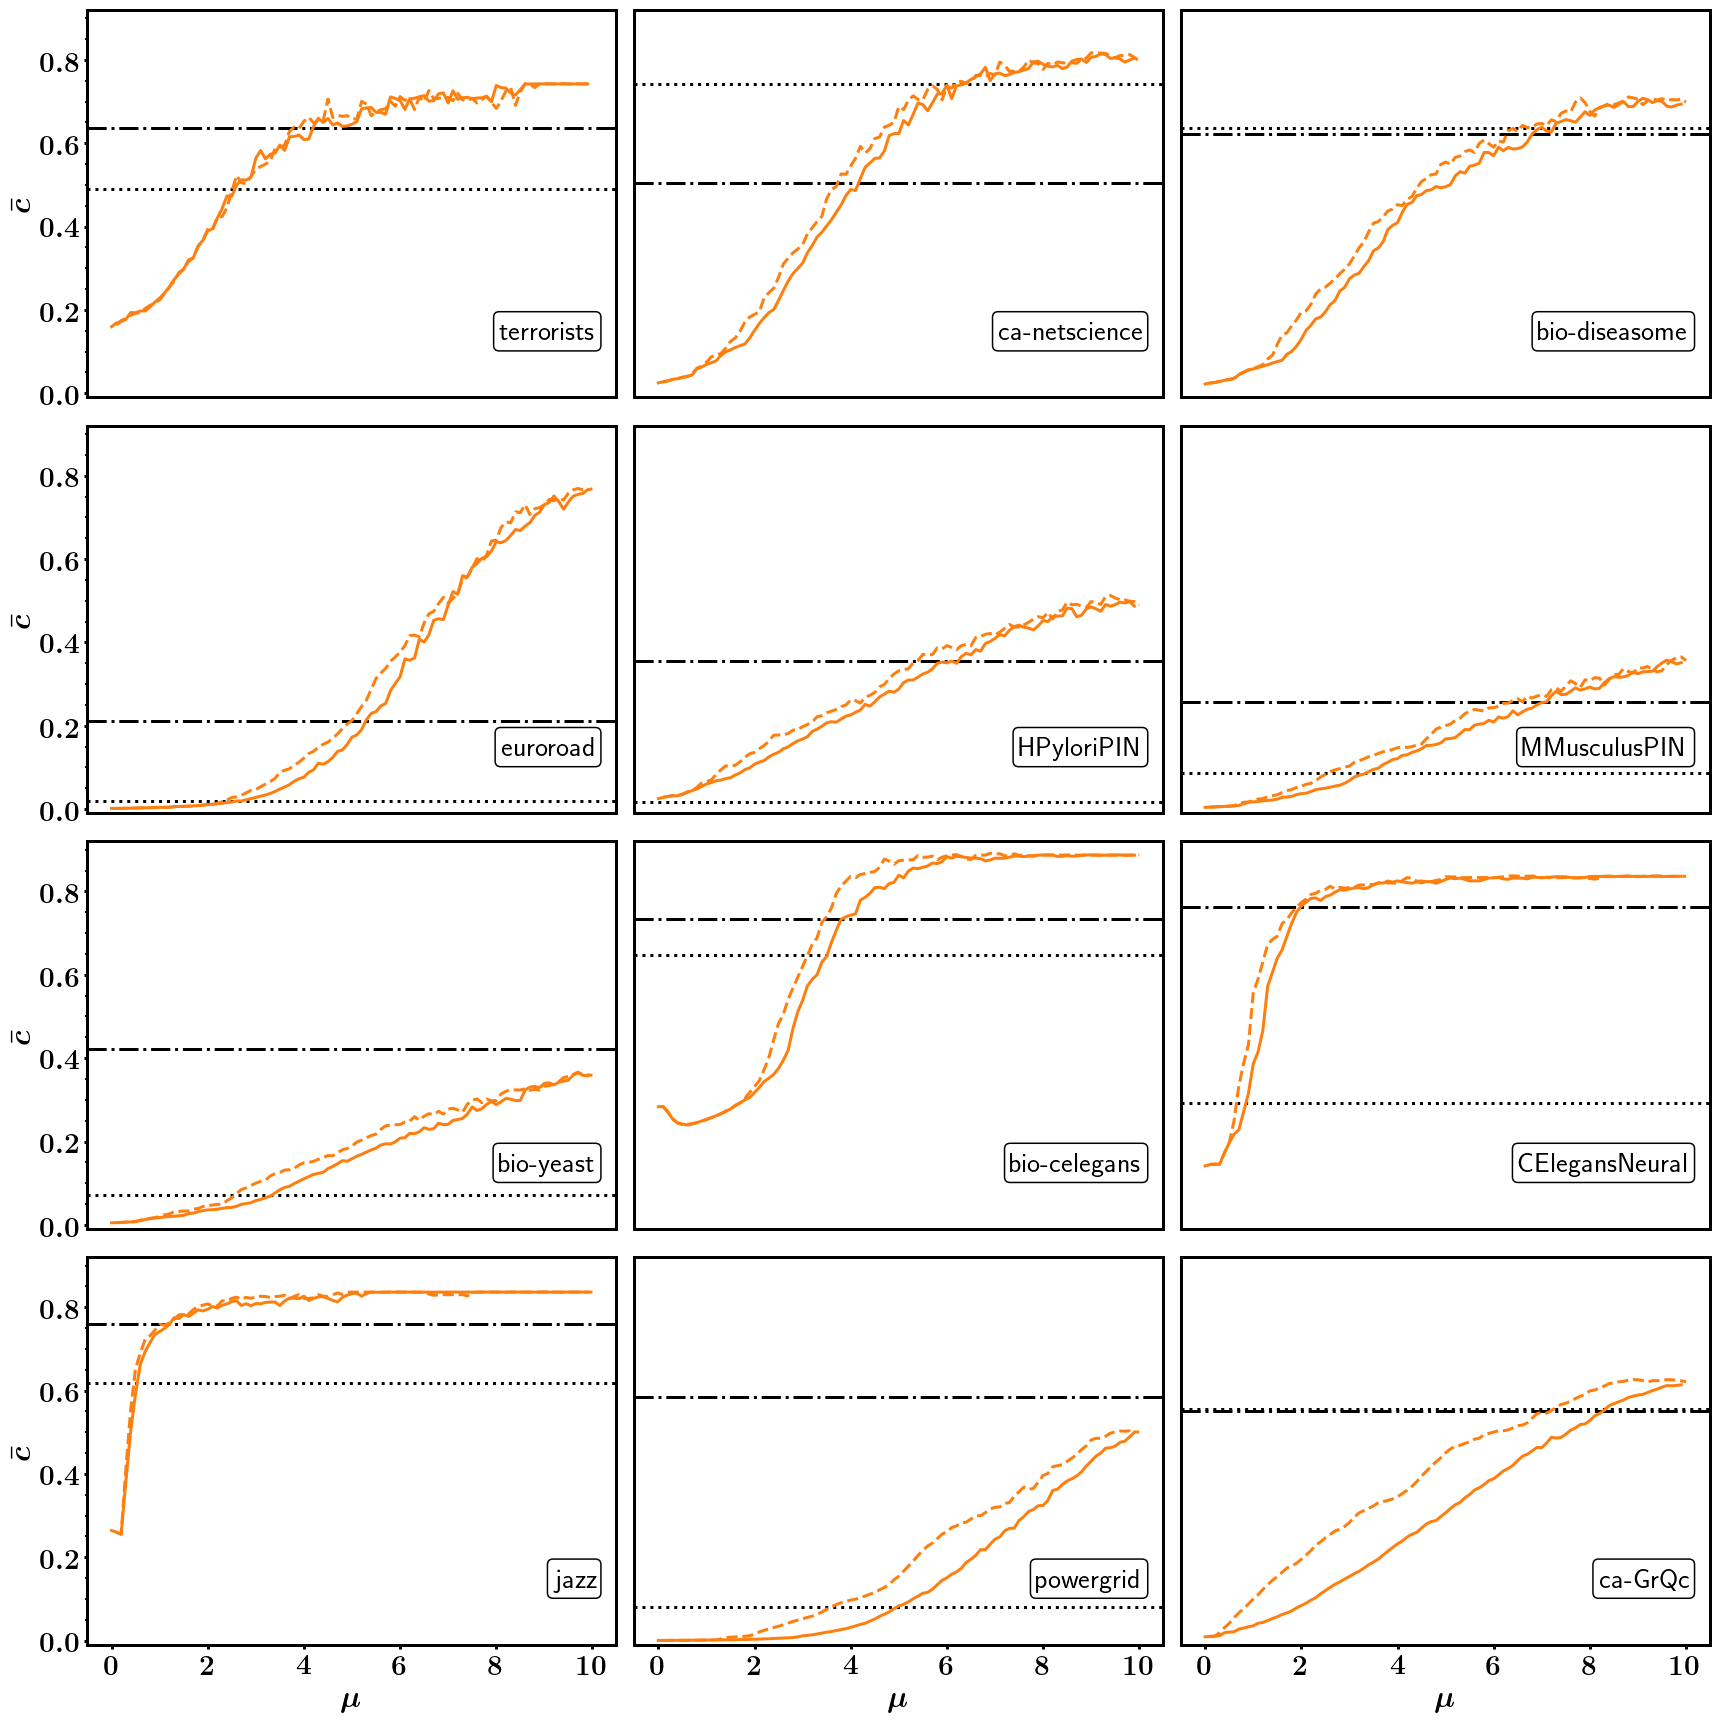

In [7]:
input_dir = '../../../data/clustering'
full_file_path = os.path.join(input_dir, 'Cnorm_data.pickle')
with open(full_file_path, 'rb') as f:
    data = pickle.load(f)
    
linestyles = ['-', '--']

ncols, nrows = 3, len(networks) // 3 + (len(networks)%3 > 0)
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axes[:,0]:
    ax.set_ylabel(r'$\bar{c}$')
    ax.set_yticks(np.arange(0, 1.2, 0.2))
for ax in axes[-1,:]:
    ax.set_xlabel(r'$\mu$')
    ax.set_xticks(np.arange(0, 11, 2))

for ax, network in zip(axes.flatten(), networks):

    Cws = data[network]['Cws'][0]
    maxCws = data[network]['Cws'][2]
    ax.axhline(Cws, linestyle=':', color='k')
    ax.axhline(maxCws, linestyle='-.', color='k')

    for i, rampe in enumerate(rampes):
        df = dfs[network][rampe]
        mean_df = df.groupby(by='mu').mean()
        mu_values = mean_df.index

        Cws_values = mean_df.Cws
        ax.plot(mu_values, Cws_values, color=colors[1], linestyle=linestyles[i], label=r'')

    if '_simple_gcc' in network:
        title = network.split('_')[0]
    else:
        title = network
    print(title)
    ax.set_ylim(-0.01, 0.92)
    bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    ax.text(0.96, 0.15, title, bbox=bbox, transform=ax.transAxes, fontsize=28, 
            horizontalalignment='right')
    
plt.tight_layout()
plt.savefig(os.path.join(draft_figs_dir, 'Cwsmax_MC_and_greedy.pdf'))
plt.savefig(os.path.join(figs_dir, 'Cwsmax_MC_and_greedy.png'))
plt.show()

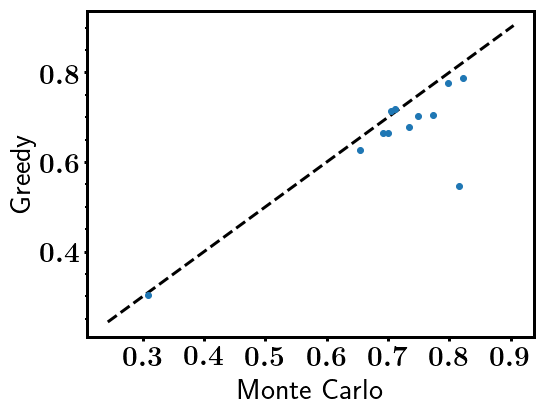

In [8]:
maxC_greedy_values = []
maxC_MC_values = []

for network in networks:
    maxC_greedy = data[network]['C'][2]
    maxC_MC = np.max([dfs[network]['annealing'].C.max(), dfs[network]['cooling'].C.max()])
    
    maxC_greedy_values.append(maxC_greedy)
    maxC_MC_values.append(maxC_MC)
    
fig, ax = plt.subplots(figsize=(8, 6))

min_x = 0.8*np.min(np.array([maxC_greedy_values, maxC_MC_values]))
max_x = 1.1*np.max(np.array([maxC_greedy_values, maxC_MC_values]))
X = np.linspace(min_x, max_x, 100)
ax.plot(X, X, '--', color='k')
ax.set_xticks(np.arange(0.2, 1.0, 0.1))

X, Y = zip(*sorted(zip(maxC_MC_values, maxC_greedy_values), key=lambda x: x[0]))
ax.plot(X, Y, 'o', label=r'$C_{\mathrm{max}}$')
ax.set_xlabel(r'Monte Carlo')
ax.set_ylabel(r'Greedy')

plt.savefig(os.path.join(draft_figs_dir, 'Cmax_MC_vs_greedy.pdf'))
plt.savefig(os.path.join(figs_dir, 'Cmax_MC_vs_greedy.png'))
plt.show()

In [9]:
data = []
for network in networks:
    full_input_file = os.path.join(net_dir, network, network + '.txt')
    try:
        g = ig.Graph().Read_Edgelist(full_input_file, directed=False)
    except:
        print('ERROR: Could not read file', network)
        continue
    N = g.vcount()
    M = g.ecount()
    deg_seq = np.array(g.degree())
    meank = deg_seq.mean()
    meank2 = np.mean(deg_seq**2)
    data.append([network, N, M, meank, meank2])
    
columns = ['network', 'N', 'M', 'meank', 'meank2']
nets_df = pd.DataFrame(data, columns=columns)
nets_df.sort_values(by='N')

,network,N,M,meank,meank2
0,terrorists_simple_gcc,62,153,4.935484,40.451613
9,jazz_simple_gcc,198,2742,27.696970,1070.242424
8,CElegansNeural,297,2148,14.464646,376.781145
1,ca-netscience,379,914,4.823219,38.686016
7,bio-celegans,453,2025,8.940397,358.490066
2,bio-diseasome,516,1188,4.604651,41.341085
4,HPyloriPIN_simple_gcc,688,1356,3.941860,45.412791
3,euroroad_simple_gcc,1039,1305,2.512031,7.753609
5,MMusculusPIN_simple_gcc,1229,1612,2.623271,16.592352
6,bio-yeast,1458,1948,2.672154,19.045267


In [10]:
def build_df(net_dir, network, n_seeds, rand_mcs, samples):
    seeds = range(1, n_seeds+1)
    
    data = []
    for seed in seeds:

        seed_dir = 'seed{:05}'.format(seed)
        protocol = 'relaxation_randMCS{}_samples{}'.format(rand_mcs, samples)
        input_dir = os.path.join(net_dir, network, protocol, seed_dir)
        if not os.path.isdir(input_dir):
            print(input_dir)
        files = sorted(os.listdir(input_dir))  

        for f in files:
            swap = float(f[1:-4])
            full_path = os.path.join(input_dir, f)
            g = ig.Graph().Read_Edgelist(full_path, directed=False)
            C = g.transitivity_undirected(mode='zero')
            Cws = g.transitivity_avglocal_undirected(mode='zero')
            data.append([seed, swap, C, Cws])
    data = sorted(data, key=lambda x: x[0])    
    arr_data = np.array(data)

    columns = ['seed', 'swap', 'C', 'Cws']
    df = pd.DataFrame(data, columns=columns)
    return df

In [11]:
relax_dfs = {}
relax_mean_dfs = {}
relax_std_dfs = {}

In [12]:
net_dir = '../../../networks/real'
n_seeds = 10
rand_mcs = 100
samples = 100

networks = ['terrorists_simple_gcc',
            'ca-netscience', 
            'ca-GrQc',
            'bio-yeast',
            'bio-diseasome',
            'bio-celegans',
            'powergrid',
            'euroroad_simple_gcc',
            'CElegansNeural',
            'polblogs_simple_gcc',
            'EColiPIN_simple_gcc',
            #'US-airports-500'
            'CElegansPIN_simple_gcc',
            'SCerevisiaePIN_simple_gcc',
            'school_day_1_duration',
            'HSapiensPIN_simple_gcc'
            ]

for network in networks:
    print(network)
    if network in relax_dfs:
        continue
        
    df = build_df(net_dir, network, n_seeds, rand_mcs, samples)
    
    mean_df = df.groupby(by='swap').mean()
    del mean_df['seed']
    std_df = df.groupby(by='swap').std()
    del std_df['seed']

    relax_dfs[network] = df
    relax_mean_dfs[network] = mean_df
    relax_std_dfs[network] = std_df

terrorists_simple_gcc
ca-netscience
ca-GrQc
bio-yeast
bio-diseasome
bio-celegans
powergrid
euroroad_simple_gcc
CElegansNeural
polblogs_simple_gcc
EColiPIN_simple_gcc
CElegansPIN_simple_gcc
SCerevisiaePIN_simple_gcc
school_day_1_duration
HSapiensPIN_simple_gcc


terrorists
ca-netscience
ca-GrQc
bio-yeast
bio-diseasome
bio-celegans
powergrid
euroroad
CElegansNeural
polblogs
EColiPIN
CElegansPIN
SCerevisiaePIN
schoolday1duration
HSapiensPIN


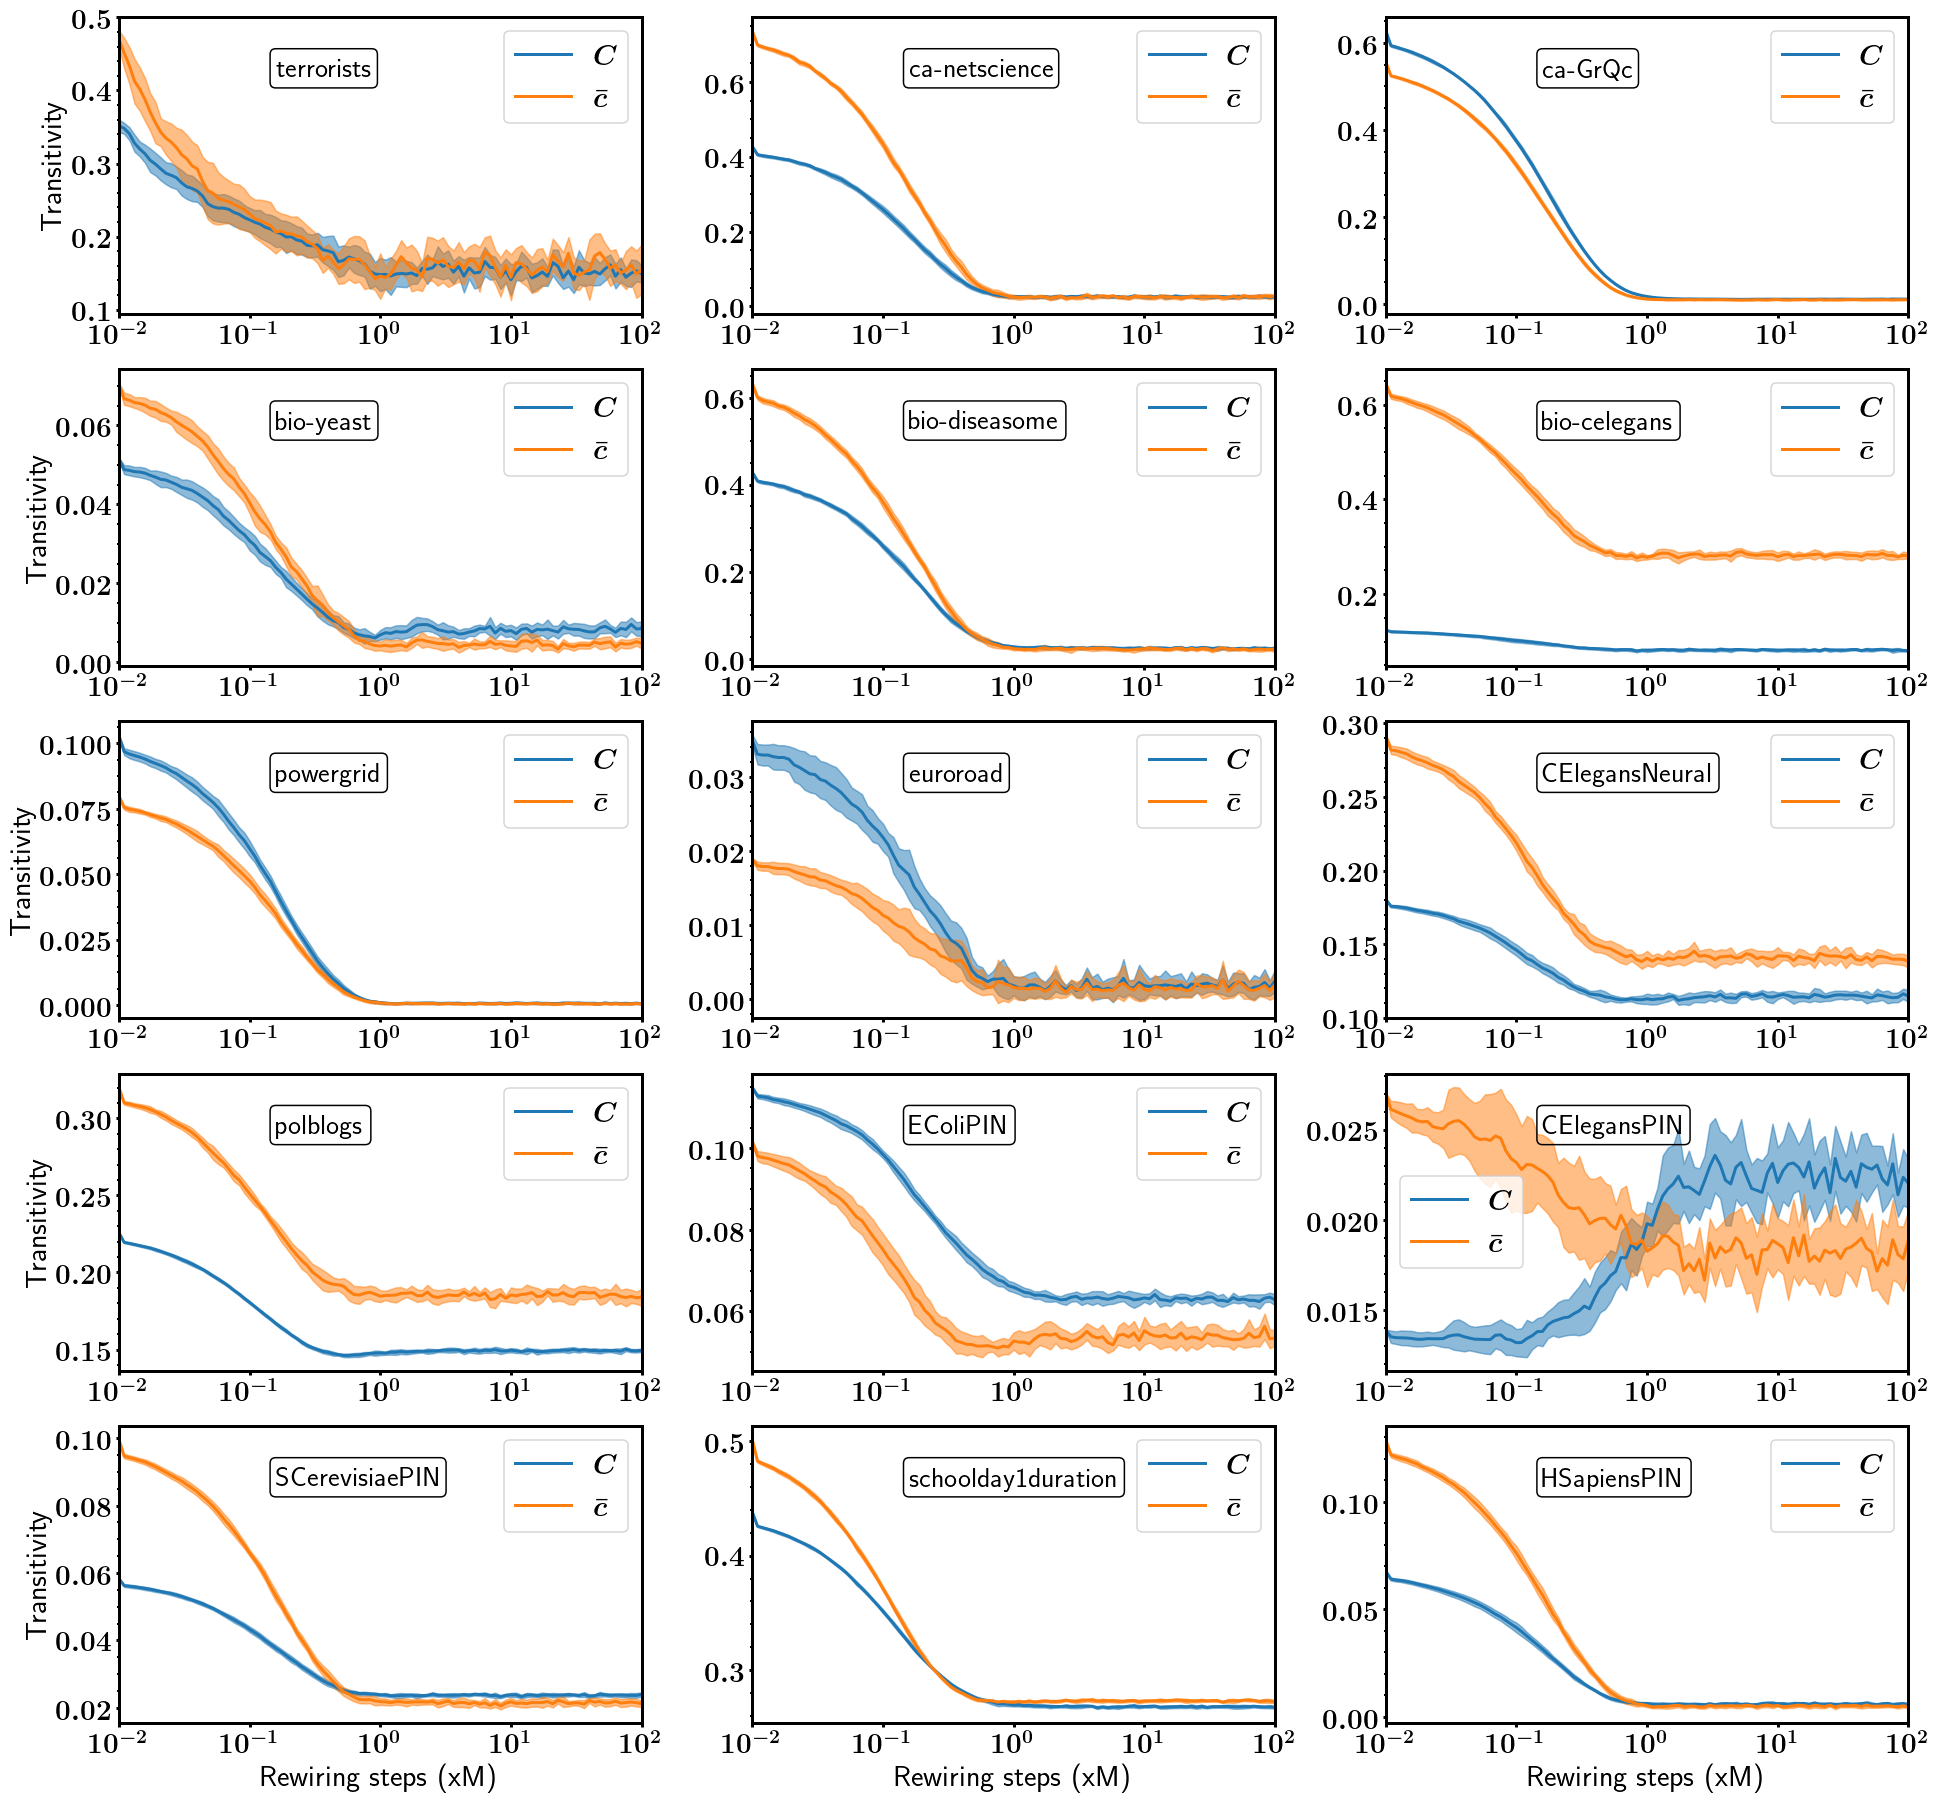

In [13]:
ncols, nrows = 3, len(networks) // 3 + ((len(networks) % 3)>0)
fig, axes = plt.subplots(figsize=(9*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(0.01, 100)
    
for ax in axes[:,0]:
    ax.set_ylabel('Transitivity')
for ax in axes[-1,:]:
    ax.set_xlabel('Rewiring steps (xM)')
    
for ax, network in zip(axes.flatten(), networks):
    df = relax_dfs[network]
    mean_df = relax_mean_dfs[network]
    std_df = relax_std_dfs[network]
    
    swap_values = mean_df.index
    C_values = mean_df.C
    Cws_values = mean_df.Cws
    ax.plot(swap_values, C_values, color=colors[0], label=r'$C$')
    ax.fill_between(swap_values, C_values-std_df.C, C_values+std_df.C, 
                    alpha=0.5, color=colors[0])
    ax.plot(swap_values, Cws_values, color=colors[1], label=r'$\bar{c}$')
    ax.fill_between(swap_values, Cws_values-std_df.Cws, Cws_values+std_df.Cws, 
                    alpha=0.5, color=colors[1])

    if '_simple_gcc' in network:
        title = network.split('_')[0]
    else:
        title = network.replace('_', '')
    print(title)
    bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    ax.text(0.3, 0.8, title, transform=ax.transAxes, bbox=bbox, fontsize=28)
    ax.legend(loc='best', fontsize=28)

plt.tight_layout()
plt.savefig(os.path.join(draft_figs_dir, 'relaxation.pdf'))
plt.savefig(os.path.join(figs_dir, 'relaxation.png'))
plt.show()

In [14]:
from clustering_methods import get_C_rand_CM

C_rand_CM_values = {}
C_rand_rewire_values = {}
Cws_rand_CM_values = {}
Cws_rand_rewire_values = {}
for network in networks:
    print(network)
    full_path = os.path.join(net_dir, network, network + '.txt')
    g = ig.Graph().Read_Edgelist(full_path, directed=False)
    degSeq = g.degree()
    C_rand_CM_values[network], Cws_rand_CM_values[network] = get_C_rand_CM(degSeq, samples=10, package='ig')
    df = relax_dfs[network]
    C_rand_rewire_values[network] = df[df['seed']==1].C[-100:]
    Cws_rand_rewire_values[network] = df[df['seed']==1].Cws[-100:]

terrorists_simple_gcc
ca-netscience
ca-GrQc
bio-yeast
bio-diseasome
bio-celegans
powergrid
euroroad_simple_gcc
CElegansNeural
polblogs_simple_gcc
EColiPIN_simple_gcc
CElegansPIN_simple_gcc
SCerevisiaePIN_simple_gcc
school_day_1_duration
HSapiensPIN_simple_gcc


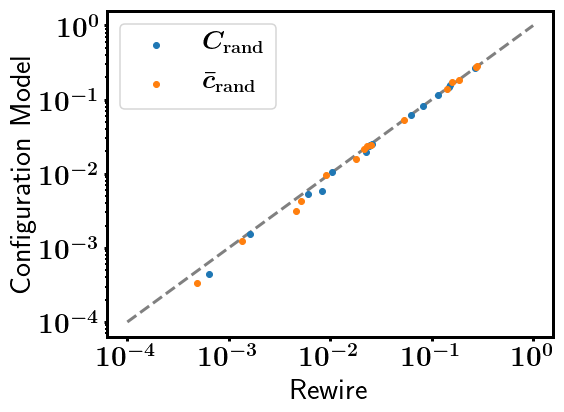

In [15]:
C_rewire_mean_values = []
Cws_rewire_mean_values = []
C_CM_mean_values = []
Cws_CM_mean_values = []
for network in networks:
    
    C_CM_mean = C_rand_CM_values[network].mean()
    C_CM_std = C_rand_CM_values[network].std()
    C_rewire_mean = C_rand_rewire_values[network].mean()
    C_rewire_std = C_rand_rewire_values[network].std()
    
    Cws_CM_mean = Cws_rand_CM_values[network].mean()
    Cws_CM_std = Cws_rand_CM_values[network].std()
    Cws_rewire_mean = Cws_rand_rewire_values[network].mean()
    Cws_rewire_std = Cws_rand_rewire_values[network].std()
    
    C_rewire_mean_values.append(C_rewire_mean)
    Cws_rewire_mean_values.append(Cws_rewire_mean)
    C_CM_mean_values.append(C_CM_mean)
    Cws_CM_mean_values.append(Cws_CM_mean)
    
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
ax.set_xscale('log')
ax.set_yscale('log')
X = np.linspace(0.0001, 1, 100)
ax.plot(X, X, linestyle='--', color='grey')
ax.plot(C_rewire_mean_values, C_CM_mean_values, 'o', 
               color=colors[0], label=r'$C_{\mathrm{rand}}$')
ax.plot(Cws_rewire_mean_values, Cws_CM_mean_values, 'o',  
               color=colors[1], label=r'$\bar{c}_{\mathrm{rand}}$')
ax.set_xlabel('Rewire')
ax.set_ylabel('Configuration Model')
ax.legend(loc='best')
plt.savefig(os.path.join(draft_figs_dir, 'CrandCM_vs_CrandRewire.pdf'))
plt.savefig(os.path.join(figs_dir, 'CrandCM_vs_CrandRewire.png'))
plt.show()

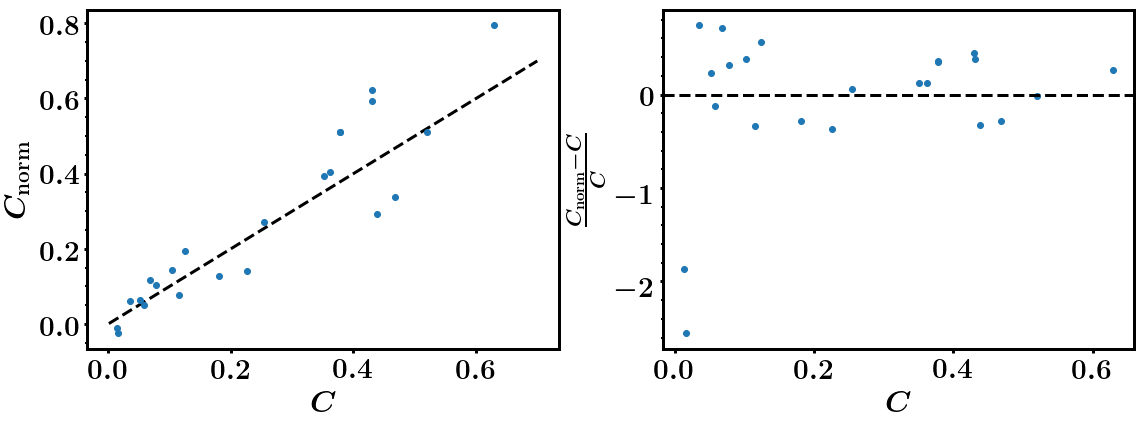

In [16]:
input_dir = '../../../data/clustering'
full_file_path = os.path.join(input_dir, 'Cnorm_data.pickle')
with open(full_file_path, 'rb') as f:
    data = pickle.load(f)
    
networks = list(data.keys())
C_values = []
Cws_values = []
for network, values in data.items():
    C_values.append(values['C'])
    Cws_values.append(values['Cws'])
C_values = np.array(C_values)
Cws_values = np.array(Cws_values)

ncols, nrows = 2, 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
#axes = axes.reshape((ncols, nrows))
X = np.linspace(0.001, 0.7, 100)

ax = axes[0]
ax.plot(X, X, linestyle='--', color='k')
ax.plot(C_values[:,0], C_values[:,3], 'o')
ax.set_xlabel(r'$C$')
ax.set_ylabel(r'$C_{\mathrm{norm}}$')

if False:
    ax = axes[1]
    ax.plot(X, X, linestyle='--', color='k')
    ax.plot(Cws_values[:,0], Cws_values[:,3], 'o')
    ax.set_xlabel(r'$\bar{c}$')
    ax.set_ylabel(r'$\bar{c}_{\mathrm{norm}}$')
    
ax = axes[1]
C_original = C_values[:,0]
C_norm = C_values[:,3]
C_relative = (C_norm - C_original)/C_original
ax.plot(C_original, C_relative, 'o')
ax.set_xlabel(r'$C$')
ax.set_ylabel(r'$\frac{C_{\mathrm{norm}}-C}{C}$')
#ax.set_ylabel(r'$(C_{\mathrm{norm}}-C)/C$')
ax.axhline(0, color='k', linestyle='--')
    
plt.tight_layout()
plt.savefig(os.path.join(draft_figs_dir, 'Cnorm_vs_C.pdf'))
plt.savefig(os.path.join(figs_dir, 'Cnorm_vs_C.png'))
plt.show()

In [17]:
columns = ['network', 'C', 'Crand', 'Cgreedy', 'Cnorm']
data = []
for network, C_data in zip(networks, C_values):
    data.append([network, *C_data])

C_df = pd.DataFrame(data, columns=columns)
C_df['Crelative'] = (C_df.Cnorm - C_df.C) / C_df.C
C_df.sort_values(by='Crelative')[['network', 'Crelative']]
#C_df.sort_values(by='Cnorm')[['network', 'Cnorm']]
#C_df.sort_values(by='C')[['network', 'C']]
#C_df

,network,Crelative
3,HPyloriPIN_simple_gcc,-2.555601
13,CElegansPIN_simple_gcc,-1.864065
8,polblogs_simple_gcc,-0.371378
5,EColiPIN_simple_gcc,-0.340461
10,school_day_1_duration,-0.330305
4,CElegansNeural,-0.287459
12,school_day_2_duration,-0.280908
0,SCerevisiaePIN_simple_gcc,-0.121989
22,jazz_simple_gcc,-0.016789
18,openflights_simple_gcc,0.061862


In [18]:
no_gcc = []
networks = os.listdir(net_dir)
for network in networks:
    if '_simple_gcc' in network:
        no_gcc.append(network[:-11])

for network in no_gcc:
    networks.remove(network)
    
networks.remove('dolphins')

sizes = []
for network in networks:
    full_input_file = os.path.join(net_dir, network, network + '.txt')
    try:
        g = ig.Graph().Read_Edgelist(full_input_file, directed=False)
    except:
        print('ERROR: Could not read file', network)
        continue
    N = g.vcount()
    M = g.ecount()
    sizes.append([network, N, M])
    
for network, N, M in sorted(sizes, key=lambda x: x[2]):
    print('{:25} {:5} {:5}'.format(network, N, M))

terrorists_simple_gcc        62   153
ca-netscience               379   914
bio-diseasome               516  1188
euroroad_simple_gcc        1039  1305
HPyloriPIN_simple_gcc       688  1356
MMusculusPIN_simple_gcc    1229  1612
bio-yeast                  1458  1948
bio-celegans                453  2025
CElegansNeural              297  2148
jazz_simple_gcc             198  2742
US-airports-500             500  2980
CElegansPIN_simple_gcc     2454  3924
school_day_2_duration       238  5539
school_day_1_duration       236  5899
powergrid                  4941  6594
HSapiensPIN_simple_gcc     4018  6754
EColiPIN_simple_gcc        2538 11515
ca-GrQc                    4158 13422
openflights_simple_gcc     2905 15645
polblogs_simple_gcc        1222 16714
SCerevisiaePIN_simple_gcc  5106 22593
PGP_simple_gcc            10680 24316


In [19]:
from triangleNet_methods import triangleGraph
import pathlib

net_dir = '../../../networks/real'
n_comp = 10
columns = ['mu', 'sample', 'N', 'M'] + ['N{:d}'.format(i) for i in range(1, n_comp+1)]
sizes = []
for network in networks:
    full_input_file = os.path.join(net_dir, network, network + '.txt')
    try:
        g = ig.Graph().Read_Edgelist(full_input_file, directed=False)
    except:
        print('ERROR: Could not read file', network)
        continue
    N = g.vcount()
    M = g.ecount()
    sizes.append([network, N, M])
networks = list(zip(*sorted(sizes, key=lambda x: x[2])))[0]
networks = networks[:4]
tr_dfs = {}
for network in networks:
    print(network)
    tr_dfs[network] = {}
    for rampe in rampes:
        print(rampe)
        
        if rampe == 'annealing':
            init_mu = min_mu
        else:
            init_mu = max_mu
            
        protocol = protocolName(mode, init_mu, step, samples, transit, decorr, rampe)
        input_dir = os.path.join(net_dir, network, 'tr_' + protocol, seed_dir)
        files = sorted(os.listdir(input_dir))
        csv_file = os.path.join(input_dir, rampe + '.csv') 
        if os.path.isfile(csv_file):
            df = pd.read_csv(csv_file)
        else:
            data = []
            for f in files:
                if 'mu' not in f:
                    continue
                mu = get_mu(f)
                sample = get_sample(f)
                if sample == 1:
                    print(mu)
                full_input_path = os.path.join(input_dir, f)
                if not os.path.isfile(full_input_path):
                    print('ERROR: could not open file', full_input_path)
                    continue
                tr_g = ig.Graph().Read_Edgelist(full_input_path)

                tr_N = tr_g.vcount()
                tr_M = tr_g.ecount()
                components = tr_g.components(mode='weak')
                Ni_values = list(sorted([len(c) for c in components], reverse=True))[:n_comp]

                data.append([mu, sample, tr_N, tr_M] + Ni_values)

            df = pd.DataFrame(data, columns=columns)
            df.to_csv(csv_file)
            
        tr_dfs[network][rampe] = df
        

terrorists_simple_gcc
annealing
cooling
ca-netscience
annealing
cooling
bio-diseasome
annealing
cooling
euroroad_simple_gcc
annealing
cooling


terrorists
ca-netscience
bio-diseasome
euroroad


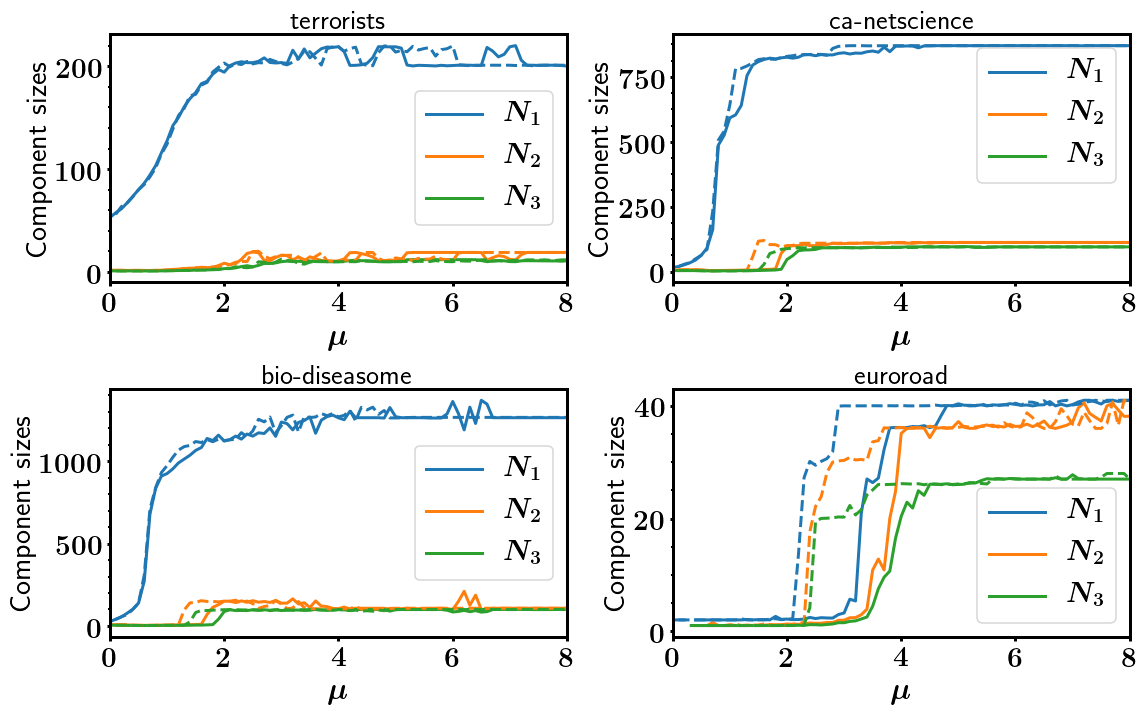

In [20]:
linestyles = ['-', '--']
ncols = 2
nrows = len(networks) // ncols + (len(networks)%ncols > 0)
fig, axes = plt.subplots(figsize=(8*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = np.array([axes])
for ax, network in zip(axes.flatten(), networks):

    for i, rampe in enumerate(rampes):
        
        df = tr_dfs[network][rampe]
        mean_df = df.groupby(by='mu').mean()
        mu_values = mean_df.index
        N1_values = mean_df.N1
        N2_values = mean_df.N2
        N3_values = mean_df.N3
        
        if rampe == 'annealing':
            ax.plot(mu_values, N1_values, color=colors[0], label=r'$N_1$')
            ax.plot(mu_values, N2_values, color=colors[1], label=r'$N_2$')
            ax.plot(mu_values, N3_values, color=colors[2], label=r'$N_3$')
        else:
            ax.plot(mu_values, N1_values, color=colors[0], linestyle='--', label='')
            ax.plot(mu_values, N2_values, color=colors[1], linestyle='--', label='')
            ax.plot(mu_values, N3_values, color=colors[2], linestyle='--', label='')
    if '_simple_gcc' in network:
        title = network.split('_')[0]
    else:
        title = network.replace('_', '')
    print(title)
    #bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    #ax.text(0.3, 0.7, title, transform=ax.transAxes, bbox=bbox, fontsize=28)
    ax.set_xlim(0, 8)
    ax.set_title(title, fontsize=28)
    ax.legend(loc='best', fontsize=28)
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel('Component sizes')
plt.tight_layout()
plt.show()

# Model networks

### Erdos-Renyi

In [126]:
model_nets_dir = '../../../networks/model'

#### Protocol data

In [134]:
mode = 'maxC'
min_mu = 0
max_mu = 10
step = 0.1
samples = 100
seed = 0
time_scaling = 2

fast = False

if fast:
    decorr = 1
    transit = 10
else:
    decorr = 10
    transit = 100

In [137]:
k = 5
if time_scaling > 1:
    seeds = range(1, 2)
else:
    seeds = range(1)
net_seed = 0
N_values = [250, 500, 1000, 2000, 4000]

ER_dir = 'ER'
ER_dir_k = ER_dir + '_k{:.2f}'.format(k)

networks = []
network_dirs = []
for N in N_values:
    ER_dir_k_N = ER_dir_k + '_N{:d}'.format(N)
    base_input_dir = os.path.join(model_nets_dir, ER_dir, ER_dir_k, ER_dir_k_N)
    for seed in seeds:
        network = ER_dir_k_N + '_{:05}_gcc'.format(net_seed)
        full_input_dir = os.path.join(base_input_dir, network)
        networks.append(network)
        network_dirs.append(full_input_dir)

rampes = ['annealing', 'cooling']
seed_dir = 'seed{:05}'.format(seed)
columns = ['mu', 'sample', 'C', 'Cws']

dfs = {}
for network, net_dir in zip(networks, network_dirs):
    print(network)
    dfs[network] = {}
    for rampe in rampes:

        if rampe == 'annealing':
            init_mu = min_mu
        else:
            init_mu = max_mu
        if time_scaling == 1:
            protocol = protocolName(mode, init_mu, step, samples, transit, decorr, rampe)
        else:
            protocol = protocolNameNew(mode, init_mu, step, samples, transit, decorr, rampe, time_scaling)
        input_dir = os.path.join(net_dir, protocol, seed_dir)
        if not os.path.isdir(input_dir):
            print(input_dir)

        csv_file = os.path.join(input_dir, rampe + '.csv')   
        if os.path.isfile(csv_file):
            df = pd.read_csv(csv_file)
        else:
            files = sorted(os.listdir(input_dir))  
            data = []
            for f in files:
                mu = get_mu(f)
                sample = get_sample(f)
                full_path = os.path.join(input_dir, f)
                g = ig.Graph().Read_Edgelist(full_path, directed=False)
                C = g.transitivity_undirected(mode='zero')
                Cws = g.transitivity_avglocal_undirected(mode='zero')
                data.append([mu, sample, C, Cws])

            df = pd.DataFrame(data, columns=columns)
            df.to_csv(csv_file)
        dfs[network][rampe] = df

ER_k5.00_N250_00000_gcc
ER_k5.00_N500_00000_gcc
ER_k5.00_N1000_00000_gcc
ER_k5.00_N2000_00000_gcc
ER_k5.00_N4000_00000_gcc


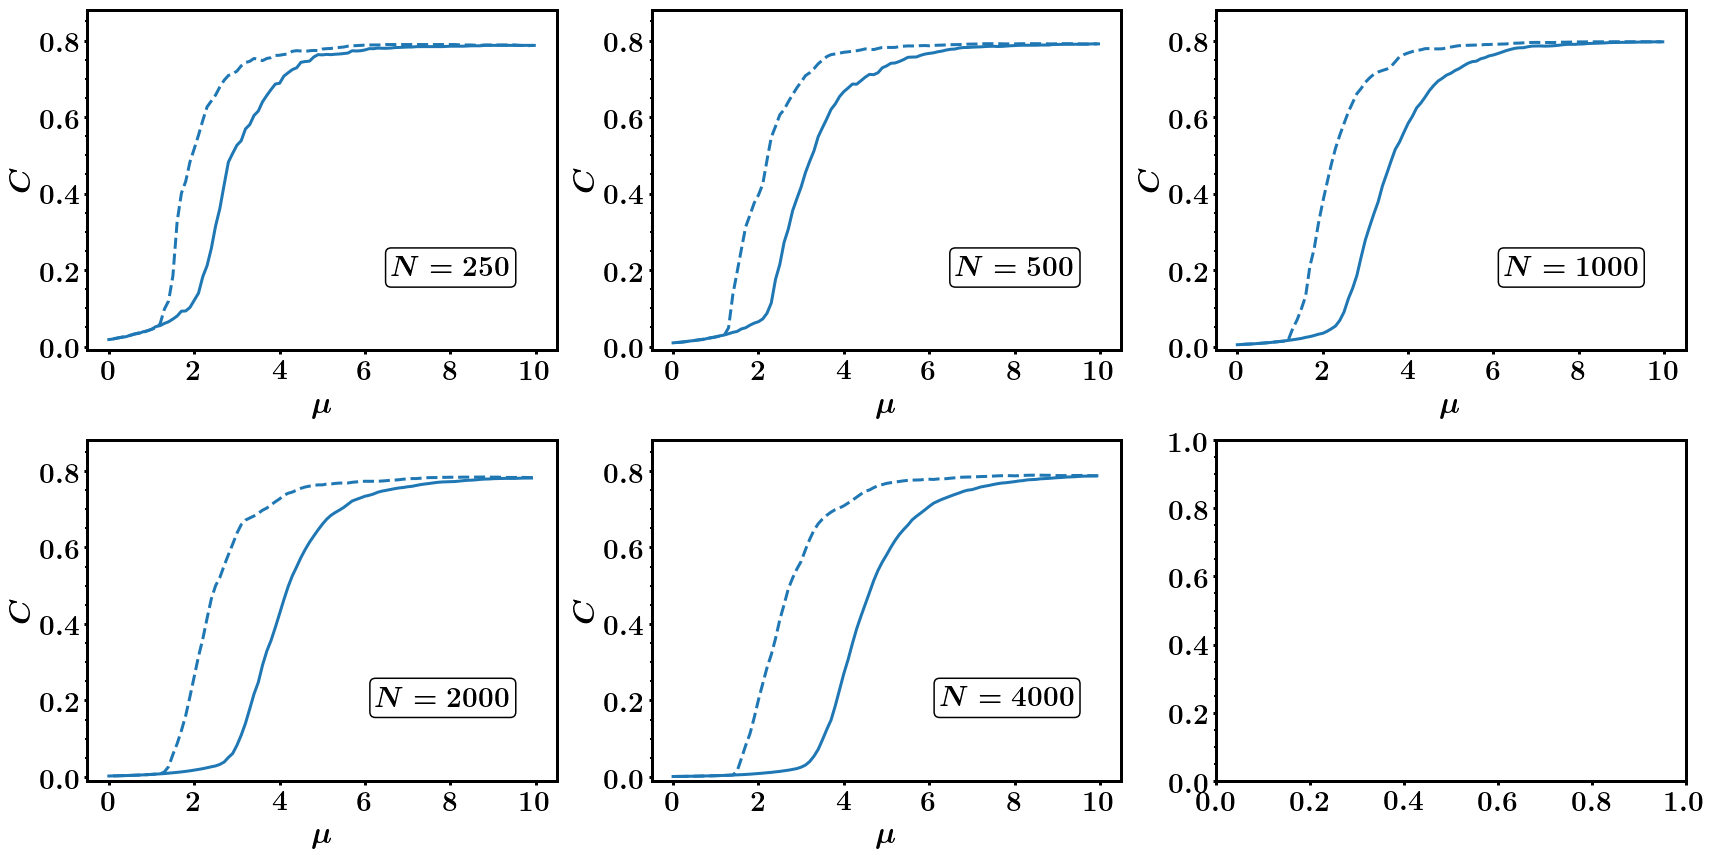

In [138]:
#input_dir = '../../../data/clustering'
#full_file_path = os.path.join(input_dir, 'Cnorm_data.pickle')
#with open(full_file_path, 'rb') as f:
#    data = pickle.load(f)

ncols = 3
nrows = len(networks) // ncols + (len(networks)%ncols > 0)
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = axes.reshape((ncols, nrows))
    
for j, (ax, network) in enumerate(zip(axes.flatten(), networks)):
    ax.set_ylabel(r'$C$')
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    ax.set_xlabel(r'$\mu$')
    ax.set_xticks(np.arange(0, 11, 2))
    ax.set_ylim(-0.01, 0.88)
    #C = data[network]['C'][0]
    #maxC = data[network]['C'][2]
    #ax.axhline(C, linestyle=':', color='k')
    #ax.axhline(maxC, linestyle='-.', color='k')
    
    for i, rampe in enumerate(rampes):
        df = dfs[network][rampe]
        mean_df = df.groupby(by='mu').mean()
        mu_values = mean_df.index
        C_values = mean_df.C
        ax.plot(mu_values, C_values, color=colors[0], linestyle=linestyles[i], label='')
    bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    ax.text(0.9, 0.22, r'$N={{{}}}$'.format(N_values[j]), bbox=bbox, 
            transform=ax.transAxes, fontsize=28, 
            horizontalalignment='right')
plt.tight_layout()

base_fig_name = 'Cmax_MC_and_greedy_ER'
if fast:
    base_fig_name += '_fast'
#plt.savefig(os.path.join(draft_figs_dir, base_fig_name + '.pdf'))
#plt.savefig(os.path.join(figs_dir, base_fig_name + '.png'))
plt.show()

### Percolation

In [139]:
k = 5
seeds = range(1, 2)
net_seed = 0
N_values = [250, 500, 1000, 2000]

ER_dir = 'ER'
ER_dir_k = ER_dir + '_k{:.2f}'.format(k)

networks = []
network_dirs = []
for N in N_values:
    ER_dir_k_N = ER_dir_k + '_N{:d}'.format(N)
    base_input_dir = os.path.join(model_nets_dir, ER_dir, ER_dir_k, ER_dir_k_N)
    for seed in seeds:
        network = ER_dir_k_N + '_{:05}_gcc'.format(net_seed)
        full_input_dir = os.path.join(base_input_dir, network)
        networks.append(network)
        network_dirs.append(full_input_dir)

rampes = ['annealing', 'cooling']
seed_dir = 'seed{:05}'.format(seed)
columns = ['mu', 'sample', 'N1', 'N2', 'meanS']

dfs_perc = {}
for network, net_dir in zip(networks, network_dirs):
    print(network)
    dfs_perc[network] = {}
    for rampe in rampes:

        if rampe == 'annealing':
            init_mu = min_mu
        else:
            init_mu = max_mu
        protocol = protocolNameNew(mode, init_mu, step, samples, transit, decorr, rampe, time_scaling)
        input_dir = os.path.join(net_dir, protocol, seed_dir)
        if not os.path.isdir(input_dir):
            print(input_dir)

        csv_file = os.path.join(input_dir, rampe + '_percolation.csv')   
        if os.path.isfile(csv_file):
            df = pd.read_csv(csv_file)
        else:
            files = sorted(os.listdir(input_dir))  
            data = []
            for f in files:
                if '.csv' in f:
                    continue
                mu = get_mu(f)
                sample = get_sample(f)
                full_path = os.path.join(input_dir, f)
                g = ig.Graph().Read_Edgelist(full_path, directed=False)
                components = g.components(mode='weak')
                comp_len = np.array(sorted([len(c) for c in components], reverse=True))
                if len(comp_len):
                    N1 = comp_len[0]
                    N2 = 0
                    meanS = 1
                else:
                    N1, N2 = comp_len[:2]
                    meanS = np.sum(comp_len[1:]**2) / np.sum(comp_len[1:])
                data.append([mu, sample, N1, N2, meanS])

            df = pd.DataFrame(data, columns=columns)
            df.to_csv(csv_file)
        dfs_perc[network][rampe] = df

ER_k5.00_N250_00000_gcc
ER_k5.00_N500_00000_gcc
ER_k5.00_N1000_00000_gcc
ER_k5.00_N2000_00000_gcc


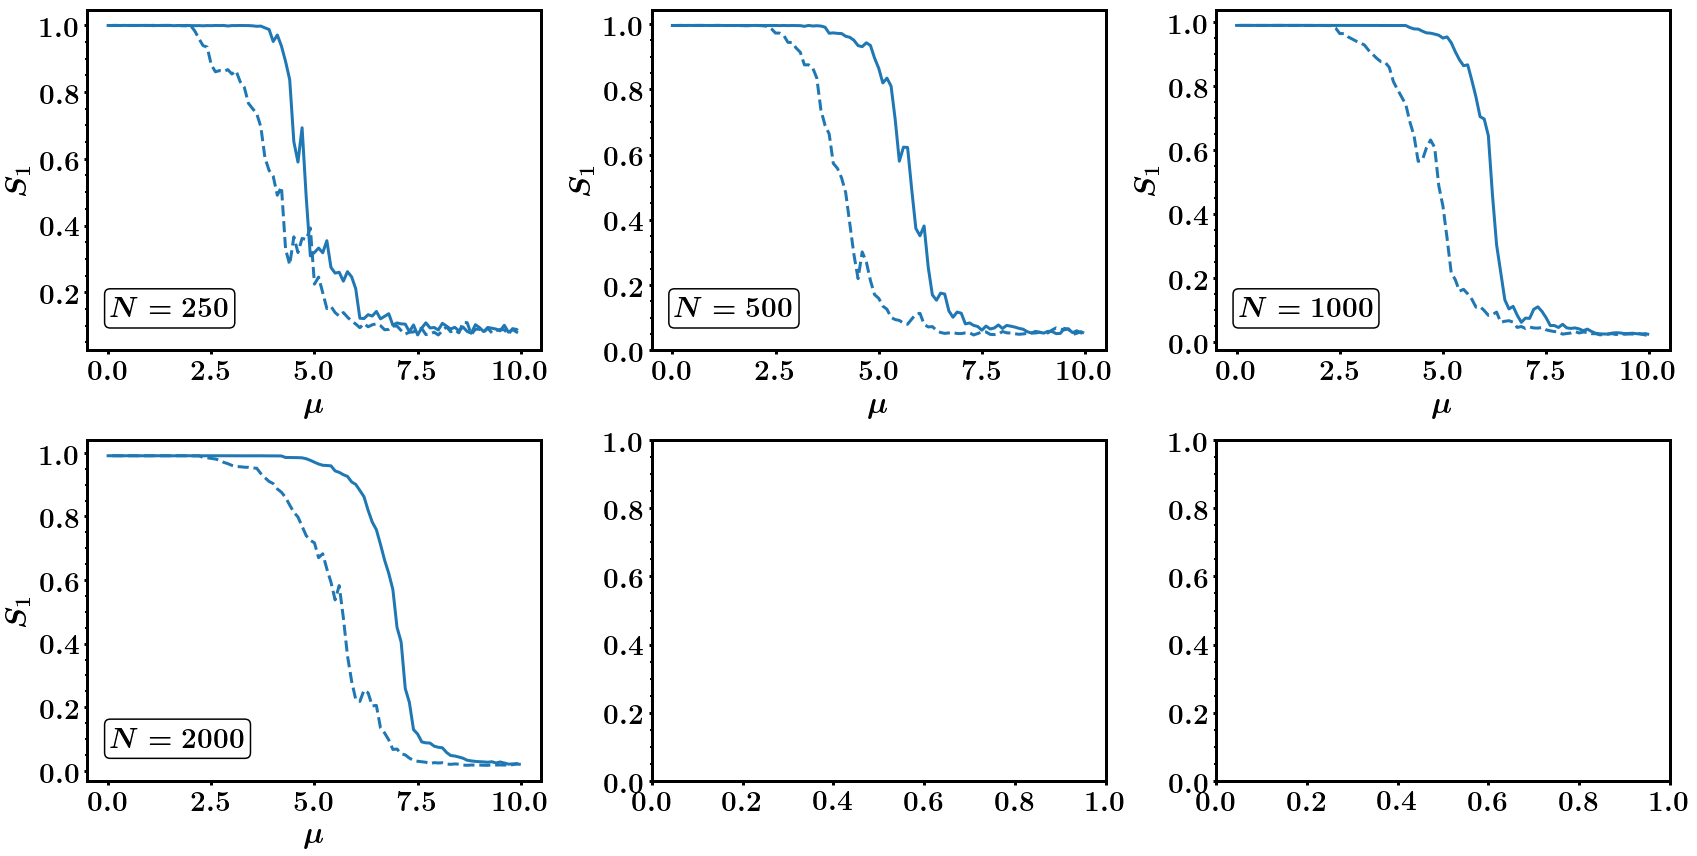

In [140]:
ncols = 3
nrows = len(networks) // ncols + (len(networks)%ncols > 0)
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = axes.reshape((ncols, nrows))
    
for j, (ax, network) in enumerate(zip(axes.flatten(), networks)):
    N = N_values[j]
    
    ax.set_ylabel(r'$S_1$')
    #ax.set_yticks(np.arange(0, 1.2, 0.2))
    ax.set_xlabel(r'$\mu$')
    #ax.set_xlim(0.6, 0.9)
    #ax.set_xscale('log')
    #ax.set_xticks(np.arange(0, 11, 2))
    #ax.set_ylim(-0.01, 1)
    
    for i, rampe in enumerate(rampes):
        df = dfs[network][rampe]
        mean_df = df.groupby(by='mu').mean()
        
        df_perc = dfs_perc[network][rampe]
        mean_df_perc = df_perc.groupby(by='mu').mean()
        
        mu_values = mean_df_perc.index
        N1_values = mean_df_perc.N1/N
        C_values = mean_df.C
        ax.plot(mu_values, N1_values, color=colors[0], linestyle=linestyles[i], label='')
        #ax.plot(C_values, N1_values, color=colors[0], linestyle=linestyles[i], label='')
    bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    ax.text(0.05, 0.1, r'$N={{{}}}$'.format(N), bbox=bbox, 
            transform=ax.transAxes, fontsize=28, 
            horizontalalignment='left')
plt.tight_layout()

base_fig_name = 'Percolation_ER'
if fast:
    base_fig_name += '_fast'
plt.savefig(os.path.join(draft_figs_dir, base_fig_name + '.pdf'))
plt.savefig(os.path.join(figs_dir, base_fig_name + '.png'))
plt.show()

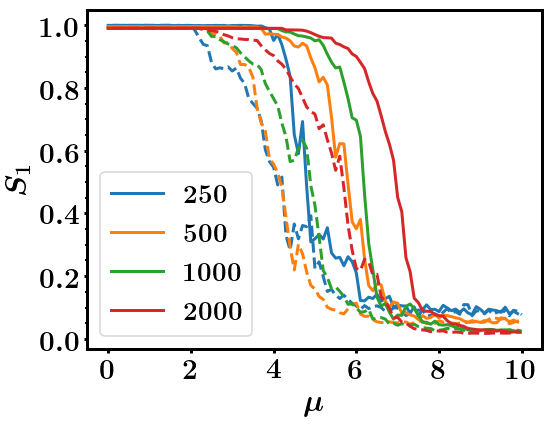

In [98]:
ncols = 1
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
ax = axes
    
for j, network in enumerate(networks):
    N = N_values[j]
    
    ax.set_ylabel(r'$S_1$')
    #ax.set_yticks(np.arange(0, 1.2, 0.2))
    ax.set_xlabel(r'$\mu$')
    ax.set_xticks(np.arange(0, 11, 2))
    #ax.set_ylim(-0.01, 1)
    
    for i, rampe in enumerate(rampes):
        df = dfs[network][rampe]
        mean_df = df.groupby(by='mu').mean()
        mu_values = mean_df.index
        N1_values = mean_df.N1/N
        if i == 0:
            ax.plot(mu_values, N1_values, color=colors[j], linestyle=linestyles[i], label=r'${{{}}}$'.format(N))
        else:
            ax.plot(mu_values, N1_values, color=colors[j], linestyle=linestyles[i], label='')
ax.legend(loc='best')
plt.tight_layout()

base_fig_name = 'Percolation_ER'
if fast:
    base_fig_name += '_fast'
#plt.savefig(os.path.join(draft_figs_dir, base_fig_name + '.pdf'))
#plt.savefig(os.path.join(figs_dir, base_fig_name + '.png'))
plt.show()

### Barabasi-Albert

In [124]:
m = 5
seeds = range(1)
N_values = [250, 500, 1000, 2000]
#N_values = [2000]
overwrite = False

BA_dir = 'BA'
BA_dir_m = BA_dir + '_m{}'.format(m)

networks = []
network_dirs = []
for N in N_values:
    BA_dir_m_N = BA_dir_m + '_N{:d}'.format(N)
    base_input_dir = os.path.join(model_nets_dir, BA_dir, BA_dir_m, BA_dir_m_N)
    for seed in seeds:
        network = BA_dir_m_N + '_{:05}'.format(seed)
        full_input_dir = os.path.join(base_input_dir, network)
        networks.append(network)
        network_dirs.append(full_input_dir)

rampes = ['annealing', 'cooling']
seed_dir = 'seed{:05}'.format(seed)
columns = ['mu', 'sample', 'C', 'Cws']

dfs = {}
for network, net_dir in zip(networks, network_dirs):
    print(network)
    dfs[network] = {}
    for rampe in rampes:

        if rampe == 'annealing':
            init_mu = min_mu
        else:
            init_mu = max_mu
        protocol = protocolName(mode, init_mu, step, samples, transit, decorr, rampe)
        input_dir = os.path.join(net_dir, protocol, seed_dir)
        if not os.path.isdir(input_dir):
            print(input_dir)

        csv_file = os.path.join(input_dir, rampe + '.csv')   
        if os.path.isfile(csv_file) and not overwrite:
            df = pd.read_csv(csv_file)
        else:
            files = sorted(os.listdir(input_dir))  
            data = []
            for f in files:
                if '.csv' in f:
                    continue
                mu = get_mu(f)
                sample = get_sample(f)
                full_path = os.path.join(input_dir, f)
                g = ig.Graph().Read_Edgelist(full_path, directed=False)
                C = g.transitivity_undirected(mode='zero')
                Cws = g.transitivity_avglocal_undirected(mode='zero')
                data.append([mu, sample, C, Cws])

            df = pd.DataFrame(data, columns=columns)
            df.to_csv(csv_file)
        dfs[network][rampe] = df

BA_m5_N250_00000
BA_m5_N500_00000
BA_m5_N1000_00000
BA_m5_N2000_00000


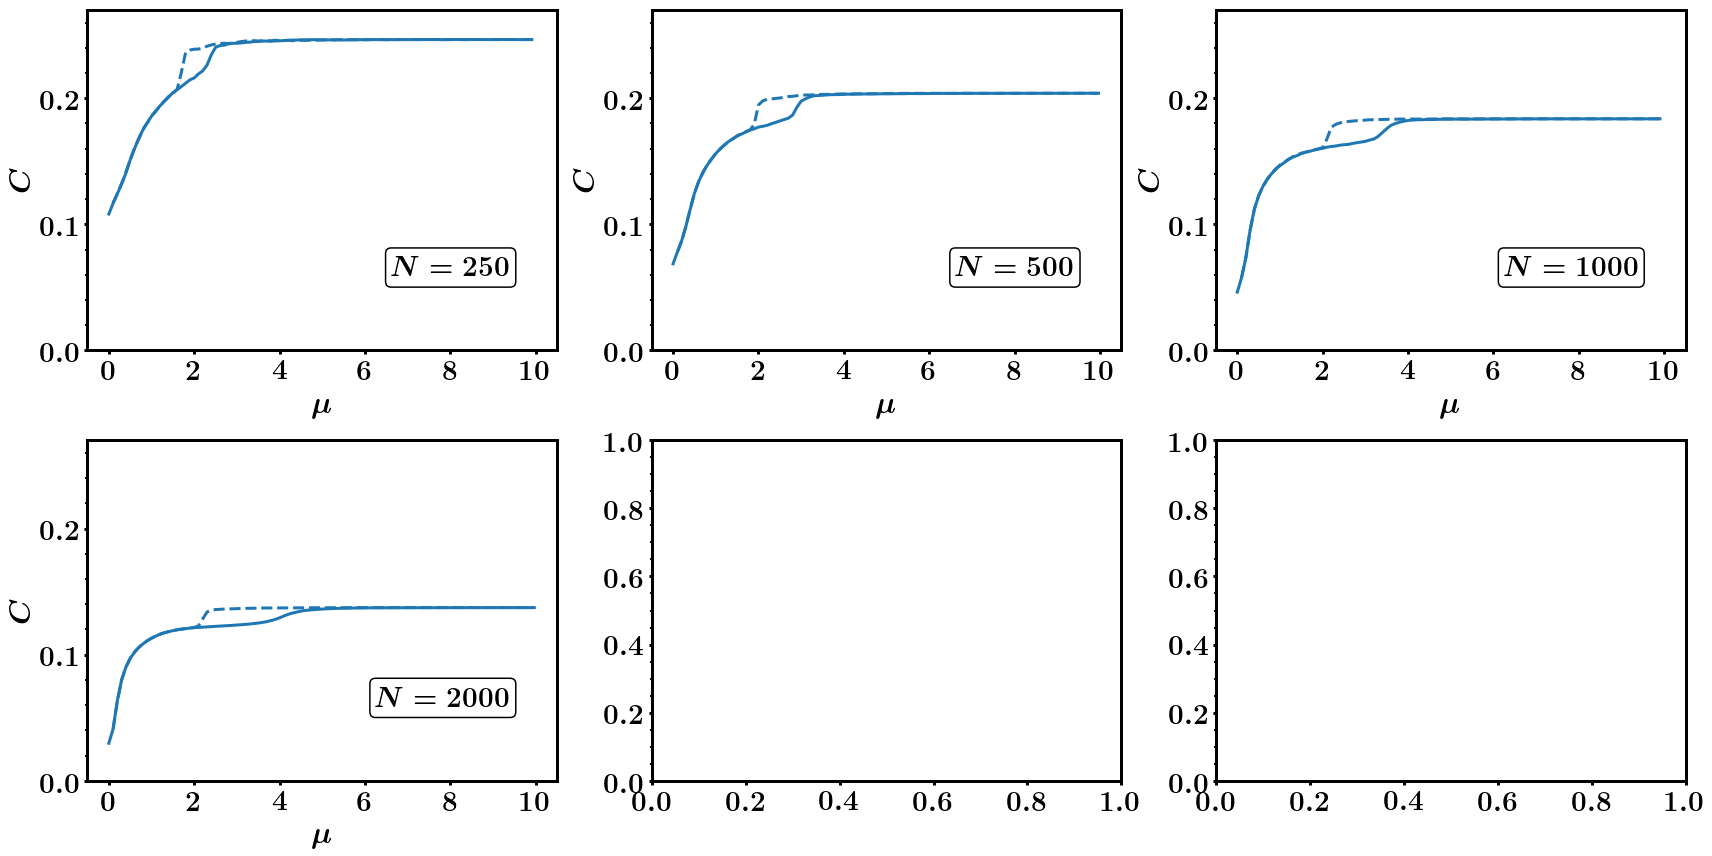

In [125]:
#input_dir = '../../../data/clustering'
#full_file_path = os.path.join(input_dir, 'Cnorm_data.pickle')
#with open(full_file_path, 'rb') as f:
#    data = pickle.load(f)

ncols = 3
nrows = len(networks) // ncols + (len(networks)%ncols > 0)
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
#axes = axes.reshape((ncols, nrows))
 
for j, (ax, network) in enumerate(zip(axes.flatten(), networks)):
#for j, network in enumerate(networks):
    ax.set_ylabel(r'$C$')
    ax.set_yticks(np.arange(0, 1.2, 0.1))
    ax.set_xlabel(r'$\mu$')
    ax.set_xticks(np.arange(0, 11, 2))
    ax.set_ylim(0, 0.27)
    #C = data[network]['C'][0]
    #maxC = data[network]['C'][2]
    #ax.axhline(C, linestyle=':', color='k')
    #ax.axhline(maxC, linestyle='-.', color='k')
    
    for i, rampe in enumerate(rampes):
        df = dfs[network][rampe]
        mean_df = df.groupby(by='mu').mean()
        mu_values = mean_df.index
        C_values = mean_df.C
        ax.plot(mu_values, C_values, color=colors[0], linestyle=linestyles[i], label='')
    bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    ax.text(0.9, 0.22, r'$N={{{}}}$'.format(N_values[j]), bbox=bbox, 
            transform=ax.transAxes, fontsize=28, 
            horizontalalignment='right') 
plt.tight_layout()
base_fig_name = 'Cmax_MC_and_greedy_BA'
if fast:
    base_fig_name += '_fast'
plt.savefig(os.path.join(draft_figs_dir, base_fig_name + '.pdf'))
plt.savefig(os.path.join(figs_dir, base_fig_name + '.png'))
plt.show()

### Hybrid model